# Alarm Episodes Benchmark Analysis

This notebook creates an Excel sheet with alarm episode information including:
- Start time
- End time
- Duration of episode
- Resolution_Benchmark (14 minutes)
- Hasdeviation (True if duration >= 14 minutes)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [8]:
# Load SSD data
ssd_file = 'DATA/SSD_1071_SSD_output_1071_7Jan2026.xlsx'
ssd_df = pd.read_excel(ssd_file)
episodes_operated_tags_df = pd.read_excel('/home/h604827/ControlActions/RESULTS/episode_all_operator_action_plots/episodes_all_with_actions_and_deviations.xlsx')

# Display data info
print(f"Shape: {ssd_df.shape}")
print(f"\nColumns: {ssd_df.columns.tolist()}")
print(f"\nFirst few rows:")
ssd_df.head(10)

Shape: (10107, 31)

Columns: ['AlarmStart_rounded_minutes', 'AlarmEnd_rounded_minutes', 'TagName', 'Units', 'Tag_First_Transition_Start_minutes', 'Latest_Transition_Start_Time_minutes', 'Latest_Transition_End_Time_minutes', 'PV_at_latest_transition_start', 'PV_at_latest_transition_end', 'Max_Change_within_transition', 'Slope_degree', 'Slope_Post_Transition_degree', 'Rate_of_Change_entire_transition_window', 'Volatility', 'Slope_degree_Standardized', 'Slope_Post_Transition_degree_Standardized', 'Rate_of_Change_entire_transition_window_Standardized', 'Transition_Change_Percent', 'MaxChangePercent_from_LatestTransitionStart_to_Alarm', 'MaxChangeStartTime', 'MaxChangeEndTime', 'MaxChangeStartValue', 'MaxChangeEndValue', 'MaxMinChangePercentageTransitionToAlarm', 'MaxValueTime', 'MaxValue', 'MinValueTime', 'MinValue', 'equipmentName', 'Depth', 'Stream']

First few rows:


,AlarmStart_rounded_minutes,AlarmEnd_rounded_minutes,TagName,Units,Tag_First_Transition_Start_minutes,Latest_Transition_Start_Time_minutes,Latest_Transition_End_Time_minutes,PV_at_latest_transition_start,PV_at_latest_transition_end,Max_Change_within_transition,Slope_degree,Slope_Post_Transition_degree,Rate_of_Change_entire_transition_window,Volatility,Slope_degree_Standardized,Slope_Post_Transition_degree_Standardized,Rate_of_Change_entire_transition_window_Standardized,Transition_Change_Percent,MaxChangePercent_from_LatestTransitionStart_to_Alarm,MaxChangeStartTime,MaxChangeEndTime,MaxChangeStartValue,MaxChangeEndValue,MaxMinChangePercentageTransitionToAlarm,MaxValueTime,MaxValue,MinValueTime,MinValue,equipmentName,Depth,Stream
0,2022-01-05 08:53:00,2022-01-05 09:33:00,03LIC_1071.PV,%,2022-01-05 08:36:00,2022-01-05 08:42:00,2022-01-05 08:52:00,55.615295,31.869987,8.069202,-74.92,NaN,0.035,7.029,-1.950,NaN,-0.149,42.695643,55.359905,2022-01-05 08:44:00,2022-01-05 08:53:00,65.262160,29.133090,124.013862,2022-01-05 08:44:00,65.262160,2022-01-05 08:53:00,29.133090,03-E-107,2.0,UPSTREAM
1,2022-01-05 08:53:00,2022-01-05 09:33:00,02FI_1000.PV,T/Hr,2022-01-05 07:28:00,2022-01-05 08:44:00,2022-01-05 08:52:00,5.804195,6.008471,0.074640,1.99,NaN,0.000,0.077,0.041,NaN,-0.150,3.519472,3.881951,2022-01-05 08:44:00,2022-01-05 08:50:00,5.804195,6.029510,3.881951,2022-01-05 08:50:00,6.029510,2022-01-05 08:44:00,5.804195,03-E-102,4.0,UPSTREAM
2,2022-01-05 08:53:00,2022-01-05 09:33:00,03FIC_1085.PV,SCMH,2022-01-05 08:37:00,2022-01-05 08:43:00,2022-01-05 08:52:00,242.092680,214.648970,86.251630,71.51,NaN,0.240,25.024,1.840,NaN,-0.143,11.336035,38.373177,2022-01-05 08:44:00,2022-01-05 08:48:00,226.325330,313.173550,79.112818,2022-01-05 08:48:00,313.173550,2022-01-05 08:53:00,174.847090,03-E-106,3.0,UPSTREAM
3,2022-01-05 08:53:00,2022-01-05 09:33:00,03FIC_3415.PV,SCMH,2022-01-05 08:36:00,2022-01-05 08:41:00,2022-01-05 08:52:00,51.664623,49.269028,5.204227,-28.35,NaN,0.042,2.644,-0.745,NaN,-0.149,4.636819,17.955658,2022-01-05 08:45:00,2022-01-05 08:50:00,56.685936,46.507603,21.885310,2022-01-05 08:45:00,56.685936,2022-01-05 08:50:00,46.507603,03-C-155,5.0,DOWNSTREAM
4,2022-01-05 08:53:00,2022-01-05 09:33:00,03FI_1151.PV,SCMH,2022-01-05 08:33:00,2022-01-05 08:37:00,2022-01-05 08:47:00,276882.000000,311842.800000,21914.880000,89.91,89.43,319.080,12185.057,2.317,3.055,8.709,12.626606,12.626606,2022-01-05 08:37:00,2022-01-05 08:42:00,276882.000000,311842.800000,12.626606,2022-01-05 08:40:00,311842.800000,2022-01-05 08:37:00,276882.000000,03-K-101,5.0,SAME
5,2022-01-05 08:53:00,2022-01-05 09:33:00,03FI_1151.PV,SCMH,2022-01-05 08:33:00,2022-01-05 08:37:00,2022-01-05 08:47:00,276882.000000,311842.800000,21914.880000,89.91,89.43,319.080,12185.057,2.317,3.055,8.709,12.626606,12.626606,2022-01-05 08:37:00,2022-01-05 08:42:00,276882.000000,311842.800000,12.626606,2022-01-05 08:40:00,311842.800000,2022-01-05 08:37:00,276882.000000,03-E-109,5.0,SAME
6,2022-01-05 08:53:00,2022-01-05 09:33:00,03LIC_1016.PV,%,2022-01-05 08:38:00,2022-01-05 08:42:00,2022-01-05 08:52:00,43.116455,13.011942,20.544943,38.78,NaN,0.287,4.689,0.993,NaN,-0.142,69.821401,195.453745,2022-01-05 08:52:00,2022-01-05 08:53:00,13.011942,38.444270,231.360645,2022-01-05 08:42:00,43.116455,2022-01-05 08:52:00,13.011942,03-E-104,3.0,UPSTREAM
7,2022-01-05 08:53:00,2022-01-05 09:33:00,03LIC_1085.PV,%,2022-01-05 08:39:00,2022-01-05 08:45:00,2022-01-05 08:52:00,56.267970,49.860157,4.474470,-5.08,NaN,0.014,2.488,-0.142,NaN,-0.149,11.388029,22.509872,2022-01-05 08:48:00,2022-01-05 08:53:00,62.299110,48.275660,29.048697,2022-01-05 08:48:00,62.299110,2022-01-05 08:53:00,48.275660,03-C-102,3.0,DOWNSTREAM
8,2022-01-05 08:53:00,2022-01-05 09:33:00,03LIC_1094.PV,%,2022-01-05 08:39:00,2022-01-05 08:45:00,2022-01-05 08:52:00,12.518971,98.886600,28.033796,86.47,NaN,0.470,11.102,2.227,NaN,-0.137,689.893994,727.269070,2022-01-05 08:45:00,2022-01-05 08:51:00,12.518971,103.565575,727.269070,2022-01-05 08:51:00,103.565

In [3]:
# Extract unique alarm episodes
# Group by alarm start and end times to get unique episodes
alarm_episodes = ssd_df[['AlarmStart_rounded_minutes', 'AlarmEnd_rounded_minutes']].drop_duplicates()

# Convert to datetime if not already
alarm_episodes['AlarmStart_rounded_minutes'] = pd.to_datetime(alarm_episodes['AlarmStart_rounded_minutes'])
alarm_episodes['AlarmEnd_rounded_minutes'] = pd.to_datetime(alarm_episodes['AlarmEnd_rounded_minutes'])

# Sort by start time
alarm_episodes = alarm_episodes.sort_values('AlarmStart_rounded_minutes').reset_index(drop=True)

print(f"Total unique alarm episodes: {len(alarm_episodes)}")
alarm_episodes.head(10)

Total unique alarm episodes: 609


,AlarmStart_rounded_minutes,AlarmEnd_rounded_minutes
0,2022-01-05 08:53:00,2022-01-05 09:33:00
1,2022-01-07 09:55:00,2022-01-07 10:00:00
2,2022-01-07 13:33:00,2022-01-07 13:36:00
3,2022-01-07 14:17:00,2022-01-07 14:19:00
4,2022-01-07 14:54:00,2022-01-07 14:58:00
5,2022-01-07 19:56:00,2022-01-07 20:02:00
6,2022-01-07 23:28:00,2022-01-07 23:31:00
7,2022-01-10 10:09:00,2022-01-10 10:15:00
8,2022-01-12 10:41:00,2022-01-12 10:45:00
9,2022-01-14 11:28:00,2022-01-14 11:35:00


In [4]:
# Create the benchmark dataframe
benchmark_df = pd.DataFrame()

# Add start and end times
benchmark_df['Start_time'] = alarm_episodes['AlarmStart_rounded_minutes']
benchmark_df['End_time'] = alarm_episodes['AlarmEnd_rounded_minutes']

# Calculate duration in minutes
benchmark_df['Duration_of_episode'] = (
    benchmark_df['End_time'] - benchmark_df['Start_time']
).dt.total_seconds() / 60

# Add Resolution_Benchmark (14 minutes)
benchmark_df['Resolution_Benchmark'] = 14

# Add Hasdeviation (True if duration >= 14 minutes)
benchmark_df['Hasdeviation'] = benchmark_df['Duration_of_episode'] >= 14

# Display summary statistics
print(f"Total alarm episodes: {len(benchmark_df)}")
print(f"\nDuration statistics:")
print(benchmark_df['Duration_of_episode'].describe())
print(f"\nEpisodes with deviation (duration >= 14 min): {benchmark_df['Hasdeviation'].sum()}")
print(f"Episodes without deviation (duration < 14 min): {(~benchmark_df['Hasdeviation']).sum()}")
print(f"\nFirst few rows:")
benchmark_df.head(10)

Total alarm episodes: 609

Duration statistics:
count    609.000000
mean      22.811166
std       42.409681
min        0.000000
25%        4.000000
50%        6.000000
75%       22.000000
max      356.000000
Name: Duration_of_episode, dtype: float64

Episodes with deviation (duration >= 14 min): 205
Episodes without deviation (duration < 14 min): 404

First few rows:


,Start_time,End_time,Duration_of_episode,Resolution_Benchmark,Hasdeviation
0,2022-01-05 08:53:00,2022-01-05 09:33:00,40.0,14,True
1,2022-01-07 09:55:00,2022-01-07 10:00:00,5.0,14,False
2,2022-01-07 13:33:00,2022-01-07 13:36:00,3.0,14,False
3,2022-01-07 14:17:00,2022-01-07 14:19:00,2.0,14,False
4,2022-01-07 14:54:00,2022-01-07 14:58:00,4.0,14,False
5,2022-01-07 19:56:00,2022-01-07 20:02:00,6.0,14,False
6,2022-01-07 23:28:00,2022-01-07 23:31:00,3.0,14,False
7,2022-01-10 10:09:00,2022-01-10 10:15:00,6.0,14,False
8,2022-01-12 10:41:00,2022-01-12 10:45:00,4.0,14,False
9,2022-01-14 11:28:00,2022-01-14 11:35:00,7.0,14,False


In [5]:
# Save to Excel
output_file = 'RESULTS/alarm_episodes_benchmark.xlsx'
benchmark_df.to_excel(output_file, index=False)

print(f"✓ Successfully saved to: {output_file}")
print(f"\nDataframe shape: {benchmark_df.shape}")
print(f"Columns: {benchmark_df.columns.tolist()}")

✓ Successfully saved to: RESULTS/alarm_episodes_benchmark.xlsx

Dataframe shape: (609, 5)
Columns: ['Start_time', 'End_time', 'Duration_of_episode', 'Resolution_Benchmark', 'Hasdeviation']


In [6]:
# Display sample of the final data
print("Sample of alarm episodes with different durations:\n")
print("Episodes with Hasdeviation = True (duration >= 14 min):")
print(benchmark_df[benchmark_df['Hasdeviation'] == True].head())
print("\n" + "="*80 + "\n")
print("Episodes with Hasdeviation = False (duration < 14 min):")
print(benchmark_df[benchmark_df['Hasdeviation'] == False].head())

Sample of alarm episodes with different durations:

Episodes with Hasdeviation = True (duration >= 14 min):
            Start_time            End_time  Duration_of_episode  \
0  2022-01-05 08:53:00 2022-01-05 09:33:00                 40.0   
13 2022-01-23 14:42:00 2022-01-23 15:39:00                 57.0   
15 2022-01-23 23:32:00 2022-01-23 23:56:00                 24.0   
19 2022-02-07 13:26:00 2022-02-07 13:57:00                 31.0   
20 2022-02-09 19:12:00 2022-02-09 19:45:00                 33.0   

    Resolution_Benchmark  Hasdeviation  
0                     14          True  
13                    14          True  
15                    14          True  
19                    14          True  
20                    14          True  


Episodes with Hasdeviation = False (duration < 14 min):
           Start_time            End_time  Duration_of_episode  \
1 2022-01-07 09:55:00 2022-01-07 10:00:00                  5.0   
2 2022-01-07 13:33:00 2022-01-07 13:36:00            

## Filtering Episodes by Operator Actions and Target Tags

Now we'll create separate sheets for episodes based on:
1. **HasOperatorActions = True**: Episodes where operators took actions
2. **HasOnlyTargetTags = True**: Episodes where only target tags were involved

In [9]:
# Explore the episodes_operated_tags_df
print(f"Episodes operated tags shape: {episodes_operated_tags_df.shape}")
print(f"\nColumns: {episodes_operated_tags_df.columns.tolist()}")
print(f"\nFirst few rows:")
episodes_operated_tags_df.head()

Episodes operated tags shape: (609, 14)

Columns: ['EpisodeID', 'AlarmStart', 'AlarmEnd', 'AlarmDurationMinutes', 'TotalWindowMinutes', 'OperatedTags', 'OperatedTagsCount', 'DeviatedTags', 'DeviatedTagsCount', 'HasOperatorActions', 'HasOnlyTargetTags', 'Has1071Action', 'Has1016Action', 'Has1013Action']

First few rows:


,EpisodeID,AlarmStart,AlarmEnd,AlarmDurationMinutes,TotalWindowMinutes,OperatedTags,OperatedTagsCount,DeviatedTags,DeviatedTagsCount,HasOperatorActions,HasOnlyTargetTags,Has1071Action,Has1016Action,Has1013Action
0,1,2022-01-05 08:53:00,2022-01-05 09:33:00,40,186,"03FIC_1085, 03FIC_3435, 03HIC_1141, 03HIC_1151...",15,"02FI_1000.PV, 03FIC_1085.PV, 03FIC_3415.PV, 03...",22,True,False,True,True,True
1,2,2022-01-07 09:55:00,2022-01-07 10:00:00,5,151,"03FIC_3435, 03GHS_0121A, 03GHS_0121AA, 03GHS_0...",8,"03FIC_1085.PV, 03FIC_3415.PV, 03FI_1141A.PV, 0...",23,True,False,False,False,False
2,3,2022-01-07 13:33:00,2022-01-07 13:36:00,3,149,"03FIC_3435, 03LIC_1034",2,"03FIC_1085.PV, 03FIC_3415.PV, 03FI_1141A.PV, 0...",19,True,False,False,False,False
3,4,2022-01-07 14:17:00,2022-01-07 14:19:00,2,148,"03FIC_3435, 03LIC_1016, 03LIC_1034",3,"03FIC_1085.PV, 03FI_1141A.PV, 03LIC_1016.PV, 0...",22,True,False,False,True,False
4,5,2022-01-07 14:54:00,2022-01-07 14:58:00,4,150,"03FIC_3435, 03LIC_1016",2,"02FI_1000.PV, 03FIC_1085.PV, 03FI_1141A.PV, 03...",19,True,False,False,True,False


In [10]:
# Check the value counts for the filtering columns
print("HasOperatorActions distribution:")
print(episodes_operated_tags_df['HasOperatorActions'].value_counts())
print(f"\nHasOnlyTargetTags distribution:")
print(episodes_operated_tags_df['HasOnlyTargetTags'].value_counts())

HasOperatorActions distribution:
HasOperatorActions
True     538
False     71
Name: count, dtype: int64

HasOnlyTargetTags distribution:
HasOnlyTargetTags
False    582
True      27
Name: count, dtype: int64


In [11]:
# Merge benchmark_df with episodes_operated_tags_df
# First, ensure datetime formats match
episodes_operated_tags_df['AlarmStart'] = pd.to_datetime(episodes_operated_tags_df['AlarmStart'])
episodes_operated_tags_df['AlarmEnd'] = pd.to_datetime(episodes_operated_tags_df['AlarmEnd'])

# Merge on start and end times
benchmark_full_df = benchmark_df.merge(
    episodes_operated_tags_df[['AlarmStart', 'AlarmEnd', 'HasOperatorActions', 'HasOnlyTargetTags', 
                                 'OperatedTagsCount', 'DeviatedTagsCount']],
    left_on=['Start_time', 'End_time'],
    right_on=['AlarmStart', 'AlarmEnd'],
    how='left'
)

# Drop the duplicate time columns
benchmark_full_df = benchmark_full_df.drop(columns=['AlarmStart', 'AlarmEnd'])

print(f"Merged dataframe shape: {benchmark_full_df.shape}")
print(f"\nColumns: {benchmark_full_df.columns.tolist()}")
benchmark_full_df.head()

Merged dataframe shape: (609, 9)

Columns: ['Start_time', 'End_time', 'Duration_of_episode', 'Resolution_Benchmark', 'Hasdeviation', 'HasOperatorActions', 'HasOnlyTargetTags', 'OperatedTagsCount', 'DeviatedTagsCount']


,Start_time,End_time,Duration_of_episode,Resolution_Benchmark,Hasdeviation,HasOperatorActions,HasOnlyTargetTags,OperatedTagsCount,DeviatedTagsCount
0,2022-01-05 08:53:00,2022-01-05 09:33:00,40.0,14,True,True,False,15,22
1,2022-01-07 09:55:00,2022-01-07 10:00:00,5.0,14,False,True,False,8,23
2,2022-01-07 13:33:00,2022-01-07 13:36:00,3.0,14,False,True,False,2,19
3,2022-01-07 14:17:00,2022-01-07 14:19:00,2.0,14,False,True,False,3,22
4,2022-01-07 14:54:00,2022-01-07 14:58:00,4.0,14,False,True,False,2,19


In [12]:
# Filter episodes with operator actions (HasOperatorActions = True)
episodes_with_actions = benchmark_full_df[benchmark_full_df['HasOperatorActions'] == True].copy()

# Select only the benchmark columns
episodes_with_actions_benchmark = episodes_with_actions[[
    'Start_time', 'End_time', 'Duration_of_episode', 'Resolution_Benchmark', 'Hasdeviation'
]]

print(f"Episodes with operator actions: {len(episodes_with_actions_benchmark)}")
print(f"Episodes with deviation (duration >= 14 min): {episodes_with_actions_benchmark['Hasdeviation'].sum()}")
print(f"Episodes without deviation (duration < 14 min): {(~episodes_with_actions_benchmark['Hasdeviation']).sum()}")
print(f"\nDuration statistics:")
print(episodes_with_actions_benchmark['Duration_of_episode'].describe())
print(f"\nFirst few rows:")
episodes_with_actions_benchmark.head()

Episodes with operator actions: 538
Episodes with deviation (duration >= 14 min): 191
Episodes without deviation (duration < 14 min): 347

Duration statistics:
count    538.000000
mean      24.726766
std       44.637394
min        0.000000
25%        4.000000
50%        7.000000
75%       24.000000
max      356.000000
Name: Duration_of_episode, dtype: float64

First few rows:


,Start_time,End_time,Duration_of_episode,Resolution_Benchmark,Hasdeviation
0,2022-01-05 08:53:00,2022-01-05 09:33:00,40.0,14,True
1,2022-01-07 09:55:00,2022-01-07 10:00:00,5.0,14,False
2,2022-01-07 13:33:00,2022-01-07 13:36:00,3.0,14,False
3,2022-01-07 14:17:00,2022-01-07 14:19:00,2.0,14,False
4,2022-01-07 14:54:00,2022-01-07 14:58:00,4.0,14,False


In [13]:
# Filter episodes with only target tags (HasOnlyTargetTags = True)
episodes_only_target = benchmark_full_df[benchmark_full_df['HasOnlyTargetTags'] == True].copy()

# Select only the benchmark columns
episodes_only_target_benchmark = episodes_only_target[[
    'Start_time', 'End_time', 'Duration_of_episode', 'Resolution_Benchmark', 'Hasdeviation'
]]

print(f"Episodes with only target tags: {len(episodes_only_target_benchmark)}")
print(f"Episodes with deviation (duration >= 14 min): {episodes_only_target_benchmark['Hasdeviation'].sum()}")
print(f"Episodes without deviation (duration < 14 min): {(~episodes_only_target_benchmark['Hasdeviation']).sum()}")
print(f"\nDuration statistics:")
print(episodes_only_target_benchmark['Duration_of_episode'].describe())
print(f"\nFirst few rows:")
episodes_only_target_benchmark.head()

Episodes with only target tags: 27
Episodes with deviation (duration >= 14 min): 11
Episodes without deviation (duration < 14 min): 16

Duration statistics:
count     27.000000
mean      21.962963
std       38.723360
min        0.000000
25%        2.500000
50%        7.000000
75%       23.000000
max      193.000000
Name: Duration_of_episode, dtype: float64

First few rows:


,Start_time,End_time,Duration_of_episode,Resolution_Benchmark,Hasdeviation
294,2024-01-28 06:44:00,2024-01-28 06:46:00,2.0,14,False
358,2024-05-12 02:15:00,2024-05-12 02:18:00,3.0,14,False
359,2024-05-12 02:50:00,2024-05-12 03:11:00,21.0,14,True
362,2024-05-18 14:18:00,2024-05-18 14:22:00,4.0,14,False
370,2024-05-26 15:33:00,2024-05-26 15:35:00,2.0,14,False


In [14]:
# Save all three datasets to separate sheets in Excel
output_file = 'RESULTS/alarm_episodes_benchmark.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Sheet 1: All episodes
    benchmark_df.to_excel(writer, sheet_name='All_Episodes', index=False)
    
    # Sheet 2: Episodes with operator actions
    episodes_with_actions_benchmark.to_excel(writer, sheet_name='HasOperatorActions', index=False)
    
    # Sheet 3: Episodes with only target tags
    episodes_only_target_benchmark.to_excel(writer, sheet_name='HasOnlyTargetTags', index=False)

print(f"✓ Successfully saved to: {output_file}")
print(f"\nSummary of sheets:")
print(f"1. All_Episodes: {len(benchmark_df)} episodes")
print(f"2. HasOperatorActions: {len(episodes_with_actions_benchmark)} episodes")
print(f"3. HasOnlyTargetTags: {len(episodes_only_target_benchmark)} episodes")

✓ Successfully saved to: RESULTS/alarm_episodes_benchmark.xlsx

Summary of sheets:
1. All_Episodes: 609 episodes
2. HasOperatorActions: 538 episodes
3. HasOnlyTargetTags: 27 episodes


In [15]:
# Detailed comparison of the three datasets
print("="*80)
print("DETAILED COMPARISON OF EPISODE TYPES")
print("="*80)

datasets = [
    ('All Episodes', benchmark_df),
    ('HasOperatorActions = True', episodes_with_actions_benchmark),
    ('HasOnlyTargetTags = True', episodes_only_target_benchmark)
]

for name, df in datasets:
    print(f"\n{name}:")
    print(f"  Total episodes: {len(df)}")
    print(f"  Episodes with deviation (≥14 min): {df['Hasdeviation'].sum()} ({df['Hasdeviation'].sum()/len(df)*100:.1f}%)")
    print(f"  Episodes without deviation (<14 min): {(~df['Hasdeviation']).sum()} ({(~df['Hasdeviation']).sum()/len(df)*100:.1f}%)")
    print(f"  Mean duration: {df['Duration_of_episode'].mean():.2f} minutes")
    print(f"  Median duration: {df['Duration_of_episode'].median():.2f} minutes")
    print(f"  Max duration: {df['Duration_of_episode'].max():.2f} minutes")
    print(f"  Min duration: {df['Duration_of_episode'].min():.2f} minutes")

DETAILED COMPARISON OF EPISODE TYPES

All Episodes:
  Total episodes: 609
  Episodes with deviation (≥14 min): 205 (33.7%)
  Episodes without deviation (<14 min): 404 (66.3%)
  Mean duration: 22.81 minutes
  Median duration: 6.00 minutes
  Max duration: 356.00 minutes
  Min duration: 0.00 minutes

HasOperatorActions = True:
  Total episodes: 538
  Episodes with deviation (≥14 min): 191 (35.5%)
  Episodes without deviation (<14 min): 347 (64.5%)
  Mean duration: 24.73 minutes
  Median duration: 7.00 minutes
  Max duration: 356.00 minutes
  Min duration: 0.00 minutes

HasOnlyTargetTags = True:
  Total episodes: 27
  Episodes with deviation (≥14 min): 11 (40.7%)
  Episodes without deviation (<14 min): 16 (59.3%)
  Mean duration: 21.96 minutes
  Median duration: 7.00 minutes
  Max duration: 193.00 minutes
  Min duration: 0.00 minutes


## Final Summary

The Excel file **`RESULTS/alarm_episodes_benchmark.xlsx`** has been successfully created with **3 separate sheets**:

### 📊 Sheet 1: All_Episodes (609 episodes)
All alarm episodes from the SSD data with baseline statistics.
- 33.7% have deviation (duration ≥ 14 minutes)
- Mean duration: 22.8 minutes
- Median duration: 6.0 minutes

### 🔧 Sheet 2: HasOperatorActions (538 episodes)
Episodes where operators took actions to resolve the alarm.
- 35.5% have deviation (duration ≥ 14 minutes)
- Mean duration: 24.7 minutes
- Median duration: 7.0 minutes

### 🎯 Sheet 3: HasOnlyTargetTags (27 episodes)
Episodes where only target tags were involved.
- 40.7% have deviation (duration ≥ 14 minutes)
- Mean duration: 22.0 minutes
- Median duration: 7.0 minutes

### Columns in each sheet:
1. **Start_time**: Timestamp when the alarm episode started
2. **End_time**: Timestamp when the alarm episode ended
3. **Duration_of_episode**: Duration in minutes
4. **Resolution_Benchmark**: Fixed at 14 minutes
5. **Hasdeviation**: True if Duration_of_episode >= 14 minutes

### Key Insights:
- **88.3%** of all episodes (538/609) involved operator actions
- **4.4%** of all episodes (27/609) involved only target tags
- Episodes with operator actions have slightly higher deviation rate (35.5% vs 33.7% overall)
- Episodes with only target tags have the highest deviation rate (40.7%)

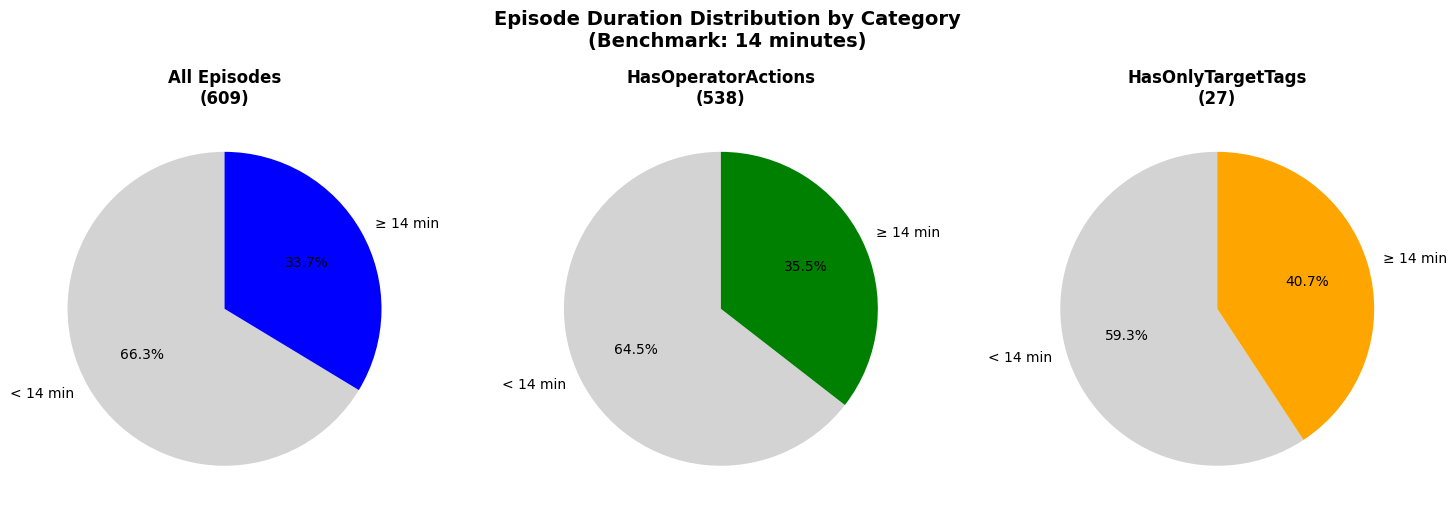

✓ Visualization saved to: RESULTS/alarm_episodes_benchmark_distribution.png


In [16]:
# Create a summary visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

datasets_info = [
    ('All Episodes\n(609)', benchmark_df, 'blue'),
    ('HasOperatorActions\n(538)', episodes_with_actions_benchmark, 'green'),
    ('HasOnlyTargetTags\n(27)', episodes_only_target_benchmark, 'orange')
]

for ax, (name, df, color) in zip(axes, datasets_info):
    deviation_counts = df['Hasdeviation'].value_counts()
    labels = ['< 14 min', '≥ 14 min']
    sizes = [deviation_counts.get(False, 0), deviation_counts.get(True, 0)]
    
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgray', color])
    ax.set_title(name, fontsize=12, fontweight='bold')

plt.suptitle('Episode Duration Distribution by Category\n(Benchmark: 14 minutes)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('RESULTS/alarm_episodes_benchmark_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to: RESULTS/alarm_episodes_benchmark_distribution.png")

In [17]:
# Verify all outputs
import os

print("="*80)
print("OUTPUT FILES VERIFICATION")
print("="*80)

output_files = [
    'RESULTS/alarm_episodes_benchmark.xlsx',
    'RESULTS/alarm_episodes_benchmark_distribution.png'
]

for file in output_files:
    if os.path.exists(file):
        file_size = os.path.getsize(file)
        print(f"✓ {file} ({file_size:,} bytes)")
    else:
        print(f"✗ {file} (NOT FOUND)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

OUTPUT FILES VERIFICATION
✓ RESULTS/alarm_episodes_benchmark.xlsx (39,099 bytes)
✓ RESULTS/alarm_episodes_benchmark_distribution.png (208,180 bytes)

ANALYSIS COMPLETE!
